In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import random
import math
import json
import ast
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ===========================================================
# ================= Data Collecting Class ===================
# ===========================================================
class data_collect():
    def __init__(self, normalize_function = 2, normalize_company = 0, num_range = 1, train_size = 70, 
                 val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, 
                 length = 25, pred_length = 5, company_group = True, random_batch = False, shuffle_test = False,
                 no_change_range = 1.70, data_points = range(0,14), kill_first_percentage = 0, kill_last_percentage = 0, label_type = 0):
        self.normalize_function = normalize_function
        self.normalize_company = normalize_company
        self.num_range = num_range
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        self.start_point_diff = start_point_diff
        self.start_point_deviation = start_point_deviation  
        self.length = length
        self.pred_length = pred_length
        self.no_change_range = no_change_range
        self.company_group = company_group
        self.random_batch = random_batch
        self.shuffle_test = shuffle_test
        self.data_points = data_points
        self.label_type = label_type
        self.kill_first_percentage = kill_first_percentage
        self.kill_last_percentage = kill_last_percentage


    def format_data(self, data, filename):
        # Generate fake data for testing if no data is given
        if (data == None):  
            # For fake data, assume dimension size
            num_data_per_day = 20
            num_companies = 160
            num_days = 830
            data = random_input_gen(num_data_per_day, num_companies, num_days)
        elif (data == True):
            # Read data from .json file
            data = read_from_database_to_list(self.data_points, filename)
            # Get length of data input
            num_data_per_day = len(data[0][0])
            num_companies = len(data[0])
            num_days = len(data)
        
        
        # Add Labels
        data = add_labels(data, self.normalize_function, self.normalize_company, self.num_range, self.pred_length, self.no_change_range, self.data_points, self.label_type)

        # Return batched the data (3 tensors)
        return batch(data, self.train_size, self.val_size, self.test_size, self.start_point_diff, self.start_point_deviation, self.length, self.pred_length, self.company_group, self.random_batch, self.shuffle_test, self.kill_first_percentage, self.kill_last_percentage)

    def get_label_frequency(self, data, dataset_type):
        data_loader = torch.utils.data.DataLoader(data, batch_size=1)
        zeros = 0
        ones = 0
        half = 0
        for data_item, data_label in data_loader:
            label_to_count = data_label.tolist()
            if (self.label_type == 0):
                if (self.company_group):
                    for i in label_to_count:
                        for j in i:
                            if (j == 0.0):
                                zeros += 1
                            elif (j == 0.5):
                                half += 1
                            elif (j == 1.0):
                                ones += 1
                else:
                    for i in label_to_count:
                        if (i == 0.0):
                            zeros += 1
                        elif (i == 0.5):
                            half += 1
                        elif (i == 1.0):
                            ones += 1
                        else:
                            print(i)
            elif (self.label_type == 1):
                if (self.company_group):
                    for i in label_to_count:
                        for j in i:
                            if (j == 0):
                                zeros += 1
                            elif (j == 1):
                                half += 1
                            elif (j == 2):
                                ones += 1
                else:
                    for i in label_to_count:
                        if (i == 0):
                            zeros += 1
                        elif (i == 1):
                            half += 1
                        elif (i == 2):
                            ones += 1
        print("0.0: " + str(zeros))
        print("0.5: " + str(half))
        print("1.0: " + str(ones))
        print(dataset_type.upper() + " SET LABEL FREQUENCY")
        print("Percent of 0.0 label: ", zeros / (zeros + ones + half))
        print("Percent of 0.5 label: ", half / (zeros + ones + half))
        print("Percent of 1.0 label: ", ones / (zeros + ones + half))
        return None

In [0]:
# ===========================================================
# ================= Random input generator ==================
# ===========================================================

# 9 input per day       --> dim 1
# 165 companies         --> dim 2
# ~763 days             --> dim 3

def random_input_gen(num_data_per_day = 20, num_companies = 160, num_days = 830, data_points = range(0,14)): # random numbers ranging from +- 100,000,000,000 (100 billion)
    data = [[[None for k in range(num_data_per_day)] for j in range(num_companies)] for i in range(num_days)]
    for i in range(num_days):
        for j in range(num_companies):
            for k in range(num_data_per_day):
                data[i][j][k] = random.randint(-100000000000,100000000001)
    # Force numbers to ensure logarithmic normalization works
    data[0][0][0] = 15
    data[0][0][1] = 0.05
    return data

# ============================================================
# ===== Formatting data from .json to dictionary to list =====
# ============================================================

# data_points = list    --> Contains all indexes that are desired
#                                   ~~~ RATIOS ~~~
#                       --> 0 = EPS, 1 = PE ratio, 2 = PPS,
#                       --> 3 = asset turnover 4 = cash flow,
#                       --> 5 = current ratio, 6 = return on equity,
#                       --> 7 = working capital
#                                 ~~~ Stock Data ~~~
#                       --> 8 = Closing stock price,
#                       --> 9 = 14-day moving avg,
#                       --> 10 = 37-day moving average

def read_from_database_to_list(data_points = range(0,14), filename = "data_list_complete.json"):      # Take in raw str, and convert to dictionary, then to list

        with open(filename, "r") as f:              # *******FILE LOCATION/NAME MAY DIFFER ACCORDING TO YOUR REQUIREMENTS******
                content = f.readlines()
        content = [x.strip() for x in content] 
        data = []
        for i in range(0,len(content)):
                data.append(ast.literal_eval(content[i]))       # Converting to dictionary

        data = data[0]
        list_companies = list(data["2019-07-17"].keys())        # All company symbols (anyday works after april 14th 2019)
        list_companies.sort(reverse = False)                    # Sort alphabetically company names

        list_days = list(data.keys())                           # All database days
        list_days = sorted(list_days, key = sorting)            # Sort days in past -> future order
                
        bad_companies = ["WLKP", "VMC", "VRS", "REX", "USLM"]   # These companies data are incomplete. To be removed (not enough data) --> I ADDED "USLM" TO MAKE IT WORK ???
        bad_days = []                                           # List of incomplete days (mostly comprised of days before april 14th 2019)

        for day in list_days:                                   # Delete bad days and companies
                num_companies = len(data[day])
                for company in list_companies:
                        if (company in bad_companies and company in data[day]):
                                del data[day][company]
                        if (num_companies < 160):
                                del data[day]
                                bad_days.append(day)
                                break

        for company in bad_companies:                           # Remove bad companies from company list
                if(company in list_companies):
                        list_companies.remove(company)

        for day in bad_days:                                    # Remove bad days from days list
                list_days.remove(day)
        
        # Give AGX data for April 14th (accidentally omitted)
        # data["2016-04-14"]["AGX"] = data["2016-04-15"]["AGX"]


        num_days = len(data)                                    # Dimensions of data
        num_companies = len(data["2016-04-15"])
        num_data_points = len(data_points)


        list_data = [[[0 for i in range(num_data_points)] for j in range(num_companies)] for k in range(num_days)]

        # Input all data to premade 3D list in order    
        counter_i = 0
        counter_j = 0
        counter_k = 0

        for day in list_days:
                for company in list_companies:
                        for data_point in data_points:
                                list_data[counter_i][counter_j][counter_k] = data[day][company][data_point]
                                counter_k += 1
                        counter_k = 0
                        counter_j += 1
                counter_j = 0
                counter_i += 1
        return list_data            # Type list with all requested data

def sorting(L):                     # Function to sort the days in chronological order
        splitup = L.split('-')
        return splitup[0], splitup[1], splitup[2]

# ===========================================================
# ====================== Normalization ======================
# ===========================================================

# normalize_function = 0    --> No normalization                (Baseline model did not train)
# normalize_function = 1    --> linear normalization            (Baseline model did not train)
# normalize_function = 2    --> logarithmic normalization       (Only function that works for baseline model)

# normalize_company = 0     --> normalize inside each company   (Only normalization that works for baseline model)
# normalize_company = 1     --> normalize across all companies  (Did not work for baseline model)

# range = 0                 --> no limit
# range = 1                 --> [-1, 1]
# range = 2                 --> [ 0, 1]

def normalize_data(data, normalize_function = 0, normalize_company = 0, num_range = 0):
    
    # Simple error checking
    if ((num_range != 0 and num_range != 1 and num_range != 2) or (normalize_company != 0 and normalize_company != 1) or (normalize_function != 0 and normalize_function != 1 and normalize_function != 2)):
        print("invalid input")
        return False

    if ((range == 1 or range == 2) and normalize_function == 0):
        print("cannot limit range with no normalization")
        return False
    
    if (range == 0 and normalize_function != 0):
        print("must limit range when normalizing data")
        return False
    
    num_days = len(data)                # Get data dimensions
    num_companies = len(data[0])
    num_data_per_day = len(data[0][0])

    if (normalize_function == 2):       # Take the log 10 of all numbers if we perform logarithmic normalization, else proceed to obtain max/min values
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = log_normalization(data[i][j][k])
    
    # 2D list to record each max/min values for each input variable type (the 8 ratios and 3 stock price data)
    maxmin_values = [[0.0,0.0] for i in range(num_data_per_day)]
    div_by_zero_count = 0
    if (normalize_company == 0 and normalize_function != 0):
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (maxmin_values[k][1] < data[j][i][k]):
                        maxmin_values[k][1] = data[j][i][k]
                    if (maxmin_values[k][0] > data[j][i][k]):
                        maxmin_values[k][0] = data[j][i][k]
                    
            # Normalize within a single company
            for j in range(num_days):
                for k in range(num_data_per_day):
                    try:
                        data[j][i][k] = (data[j][i][k] - maxmin_values[k][0]) / (maxmin_values[k][1] - maxmin_values[k][0])
                    except:
                        div_by_zero_count += 1
                        '''
                        print("Error: DIVISION BY ZERO")
                        print("day number:     ", j)
                        print("company number: ", i)
                        print("data index:     ", k)
                        '''

    elif (normalize_company == 1 and normalize_function != 0):
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (maxmin_values[k][1] < data[j][i][k]):
                        maxmin_values[k][1] = data[j][i][k]
                    if (maxmin_values[k][0] > data[j][i][k]):
                        maxmin_values[k][0] = data[j][i][k]
                    
        # Normalize for all data across all companies
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    try:
                        data[j][i][k] = (data[j][i][k] - maxmin_values[k][0]) / (maxmin_values[k][1] - maxmin_values[k][0])
                    except:
                        div_by_zero_count += 1
                        '''
                        print("Error: DIVISION BY ZERO")
                        print("day number:     ", j)
                        print("company number: ", i)
                        print("data index:     ", k)
                        '''
    print("Num zero data points: " + str(div_by_zero_count))
    # Normalize the range of the data
    if (num_range == 1):
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = (data[i][j][k] - 0.5) * 2.0

    # Return normalize data of type list
    return data

def log_normalization(x):   # Log 10 normalization function
    if (x < 0):
        return -1 * math.log10((-1 * x) + 1)
    else:
        return math.log10(x + 1)

# ===========================================================================
# ========================= Labeling and Formatting =========================
# ===========================================================================

# Label = 1  increase in price
# Label = 0  no change in price (within percent error margin no_change_range)
# Label = -1 decrease in price

def add_labels(data, normalize_function = 2, normalize_company = 0, num_range = 1, pred_length = 5, no_change_range = 1.70, data_points = range(0,14), label_type = 0):
    # Get dimensions of data
    num_days = len(data)
    num_companies = len(data[0])

    # Get closing price's index
    if (8 not in data_points):
        print("Data does not contain closing stock price")
    price_index = data_points.index(8)
    
    # Label each input with the price 5 working days later
    labeled_data = []
    labeled_data_by_day =[]
    for i in range(num_days):
        for j in range(num_companies):
            if (num_days - i > pred_length):     # We can give a label
                if (data[i][j][price_index] > data[i + pred_length][j][price_index]*(1+(no_change_range/100.0))):     # Increase in price
                    label = 1.0
                elif (data[i][j][price_index] < data[i + pred_length][j][price_index]*(1-(no_change_range/100.0))):   # Decrease in price
                    label = 0.0
                else:                           # No change in price (range of allowance)
                    label = 0.5
            else:                               # We cannot give a label (no price 5 days ahead available yet)
                label = None
            if (label != None and label_type == 1):
                label = int(label*2.0)
            labeled_data_by_day.append(label)
        labeled_data.append(labeled_data_by_day)
        labeled_data_by_day = []
    
    # Normalize the data
    normalized_data = normalize_data(data, normalize_function, normalize_company, num_range)

    # Add labels to the normalized data
    formatted_data = []
    for day in range(len(normalized_data)):
        formatted_day_data = []
        for company in range(len(normalized_data[day])):
            formatted_day_data.append([normalized_data[day][company], labeled_data[day][company]])
        formatted_data.append(formatted_day_data)
    
    # Return type list with labels attached
    return formatted_data

# ============================================================
# ========================= Batching =========================
# ============================================================

# random = False    --> means first 70% months are training, next 15% are validation
#                       and next 15% are test (assuming percentages did not change)
# random = True     --> randomly pick 70% of months, 15% of months, and 15% of months for 
#                       train/val/test data

# start_point_diff  --> how far apart are the first days in adjacent batchs

# train_size, val_size, test_size   --> percentage of batches to be in each set (must add to 100%)

# start_point_deviation --> the start_point can deviate +- 5 (for example) from the original start_point_diff it was set for

# length        --> how many days in one "item". Days being the days where the market is open for trade

# company_group = True  --> all 165 companies at once
# company_group = False --> 1 company at a time

def batch(data, train_size = 70, val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, length = 25, pred_length = 5, company_group = True, random_batch = False, shuffle_test = False, kill_first_percentage = 0, kill_last_percentage = 0):
    # Ensure percentages add up properly
    if (train_size + val_size + test_size != 100):
        print("ensure train_size + val_size + test_size = 100%")
        return None, None, None

    num_days = len(data)
    num_companies = len(data[0])

    # Use start_point_diff, start_point_deviation, and length to get the day stamps we will cover
    times = []
    time_start = 0
    while((time_start + length + pred_length) < num_days):  # Note that the case where we deal with individual companies, we still give the same start date for each batch item
        times.append(time_start)
        time_start = time_start + start_point_diff
    
    for time in range(0,len(times)):
        if (times[time] != 0):
            times[time] += random.randint(-pred_length,pred_length)
   
    # Batching the data
    # Batch data according to start_point_diff, start_point_deviation, length, and company_group
    batched_data = []
    if (company_group):                                    # All 200 companies at once (for finding relationship between companies)
        for i in times:                                    # Iterate through start days
            single_batch = []
            price_label = []
            for day in range(i, i + length):               # Iterate through the length of data per item
                count = 0
                single_day = []
                for companies in range(num_companies):
                    for ratios in data[day][companies]:    # Iterate through all companies
                        if (type(ratios) is list):
                            single_day.append(ratios)
                            count += 1
                        elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                            price_label.append(ratios)
                single_batch.append(single_day)
            if (price_label != []):
                batched_data.append([single_batch,price_label])
    else:                                                   # sOne company at a time (no relationship between companies)
        for i in times:                                         # Iterate through start days
            for companies in range(num_companies):               # Iterate through the length of data per item
                price_label = None
                single_company = []
                for day in range(i, i + length):
                    for ratios in data[day][companies]:    # Iterate through all companies
                        if (type(ratios) is list):
                            single_company.append(ratios)
                        elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                            price_label = ratios
                if (price_label != None):
                    batched_data.append([single_company,price_label])
                    
    batched_data = batched_data[int(len(batched_data) * (kill_first_percentage)):int(len(batched_data) * (1-kill_last_percentage))]
        
    train_val_split = int(len(batched_data)*train_size/100.0)
    val_test_split = int(len(batched_data)*(train_size + val_size)/100.0)
    
    if (random_batch):
        if (shuffle_test == False): 
            test = batched_data[val_test_split:]
            batched_data = batched_data[:val_test_split]
            random.shuffle(batched_data)    
            train = batched_data[:train_val_split]
            val = batched_data[train_val_split:]
        else:
            random.shuffle(batched_data)    
            train = batched_data[:train_val_split]
            val = batched_data[train_val_split:val_test_split]
            test = batched_data[val_test_split:]
    else:    
        train = batched_data[:train_val_split]
        val = batched_data[train_val_split:val_test_split]
        test = batched_data[val_test_split:]

    train_data = data_to_tensor(train, company_group)
    val_data = data_to_tensor(val, company_group)
    test_data = data_to_tensor(test, company_group)
    
    # Return 3 tensors
    return train_data, val_data, test_data

def data_to_tensor(batched_data, company_group):
    tensor_data = []
    if (company_group):
      for i in batched_data:
        item_tuple = (torch.FloatTensor(i[0]),torch.as_tensor(i[1]))
        tensor_data.append(item_tuple)
    else:
      for i in batched_data:
        item_tuple = (torch.FloatTensor(i[0]),torch.as_tensor(i[1]))
        tensor_data.append(item_tuple)
    # Return data tensor and label tensor together in a tuple
    return tensor_data

In [0]:
# ===================================================================
# ==================== EXPLANATION OF PARAMETERS ====================
# ===================================================================

# ------ Data Dimensions ------
# 9 input per day       --> dim 1 (if we only want to do stock prices, we can extract it ourselves)
# 165 companies         --> dim 2
# ~763 days             --> dim 3
 
# ------ Data input ------
# data = None       (randomly generate between -100 billion and 100 billion)
# data = Some_list  (normal input)

# ------ Normalization ------
# normalize_function = 0    (no normalization)
# normalize_function = 1    (linear normalization) --> Horibly failed for random case, prob for real case too
# normalize_function = 2    (logarithmic normalization)

# normalize_company = 0     (normalize within each company)
# normalize_company = 1     (normalize across all companies)

# num_range = 0             (no normalization range)
# num_range = 1             (normalization range [-1,1])
# num_range = 2             (normalization range [0,1])

# ------ Batching ------
# start_point_diff = m          (m working days between two adjacent batch items) --> Influences size of train/val/test dataset
#                               ex. start_point_diff = 25                                   -->     start_days = [0,25,50,75,100,...]
# start_point_deviation = n     (+- n days for deviation from the evenly split start points. Cannot go below 0.)
#                               ex. start_point_diff = 25, start_point_deviation = 5        -->     start_days = [2,24,55,70,100...]
# pred_length = x               (x days worth of data history per item)
# company_group = True          Batch items by all companies in one set. Will produce a label of size [num_companies]   
#                               -->     less train/val/test data (but potentially learns company relations)
# comapny_group = False         Batch items by individual company. Will produce a label of size 1
#                               -->     more train/val/test data (but no company relations)
# random = True                 split train/val/test set randomly (no chronological order)
# random = False                split train/val/test set chrnologically (train fist, then validation, then test)

# ------ Labeling ------
# no_change_range = x           (+-x% deviation is to be considered that the price has not changed)
# label_type = 0                One classification --> MSELoss or BCEWithLogitsLoss
# label_type = 1                Many classifications --> CrossEntropyLoss
# ~below are not parameters, but just the label in the data~
# label = 0                     (decrease in price)
# label = 0.5                   (no change in price, within the error margin no_change_range)
# label = 1                     (increase in price)
# Note: depending on company_group = True / False, the label may be a single number after each batch item, or a 1D-list of size num_companies

In [0]:
# ========================================
# =============== Get Data ===============
# ========================================

# True means get data from .json database. None means use random data
# can use, for example data_single_company.get_label_frequency(train_data_single, "Train") to print label frequencies (return True)

filename = "/content/gdrive/My Drive/Colab Notebooks/Stock Price Direction Prediction/Data/data_list_complete.json"
#filename = "/content/gdrive/My Drive/Colab Notebooks/Stock Price Direction Prediction/Data/data_list_complete_random.json"

In [0]:
# Data for a single company

                             data =  data_collect(normalize_function = 2,       # Normalization Function
                                                                                # 0 = None, 1 = Linear, 2 = Logarithmic
                                                  normalize_company = 0,        # Normalization Domain
                                                                                # 0 = within each company, 1 = across all companies
                                                  num_range = 2,                # Normalization Data Range
                                                                                # 0 = no limit, 1 = [-1,1], 2 = [0,1]
                                                  train_size = 70,              # Training data percent size of whole dataset
                                                  val_size = 15,                # Validation data percent size of whole dataset
                                                  test_size = 15,               # Test data percent size of whole dataset
                                                  start_point_diff = 1,         # Difference in number of dats between two adjacent
                                                                                # days in dataset
                                                  start_point_deviation = 0,    # Random deviation (of number of days) from initial
                                                                                # start point. Initial start points set by
                                                                                # start_point_diff
                                                  length = 25,                  # Number of days worth of data in single item       
                                                  pred_length = 5,              # How far to look ahead for price direction comparison
                                                                                # (unit is in number of trading days)
                                                  company_group = True,         # Grouping companies in dataset
                                                                                # True = all 160 companies simultaneously (all-companies)
                                                                                # False = each company individually (generic model)
                                                  random_batch = True,          # Train/val/test ordering
                                                                                # (True = randomly, False = chronological)
                                                                                # Note that test will remain chronologically at the end
                                                                                # if shuffle_test = False
                                                  shuffle_test = False,         # True = shuffle the test with train/val
                                                                                # False = do not shuffle test with train/val
                                                  no_change_range = 1.70,       # +- % allowance to be considered neutral price direction
                                                                                # BEST VALUE IS 1.70 (even split)--> for pred_length = 5
                                                  data_points = range(0,14),    # Data poitns to include
                                                                                # 0-7 represent the 8 ratios, 8 = closing stock price
                                                                                # 9 = 14-day moving average, 10 = 37-day moving average
                                                                                # 11 = 14-day stochastic moving oscillator
                                                                                # 12 = 3-day stochastic moving average
                                                                                # 13 = relative strength index
                                                  kill_first_percentage = 0.30, # Remove first __ percentage of data
                                                  kill_last_percentage = 0.30,  # Remove last __ percentage of data
                                                  label_type = 0)               # 0 sets up for MSELoss problem,
                                                                                # 1 sets up for Cross Entropy
                                                                                # (1 is unavailable for all companies)

                             train, val, test = data.format_data(True, filename) 

Num zero data points: 0


In [0]:
# Data for a all companies

data_all_company =  data_collect(normalize_function = 2, 
                                 normalize_company = 0, 
                                 num_range = 2,
                                 train_size = 80, 
                                 val_size = 19.5 , 
                                 test_size = 0.5, 
                                 start_point_diff = 1, 
                                 start_point_deviation = 0, 
                                 length = 25, 
                                 pred_length = 5, 
                                 company_group = True, 
                                 random_batch = True, 
                                 shuffle_test = False,
                                 no_change_range = 1.70, # BEST VALUE IS 1.70 --> for pred_length = 5
                                 data_points = range(0,14),
                                 kill_first_percentage = 0.15,
                                 kill_last_percentage = 0.15,
                                 label_type = 0)

train_data_all, val_data_all, test_data_all = data_all_company.format_data(True, filename) 

Num zero data points: 0


In [0]:
# ===============================================================
# =============== Accuracy and training functions ===============
# ===============================================================

torch.manual_seed(1000) # set random seed

def train(model, train_data, val_data, batch_size=16, num_epochs=100, lr = 0.0001, company_group = False, shuffle = False, label_type = 0, weight_decay = 0):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay = weight_decay)
    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = shuffle)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = shuffle)
    # training
    n = 0 
    for epoch in range(num_epochs):
        for data, labels in iter(train_loader):
            out = model(data).cuda()
            if (company_group == False):
                if (label_type == 0):
                    labels = labels.unsqueeze(1).cuda()
            labels = labels.cuda()
            loss = criterion(out, labels)
            loss.backward()             
            optimizer.step()              
            optimizer.zero_grad()

        # save training info
        iters.append(n)
        losses.append(float(loss)/batch_size) 
        
        for data, labels in iter(val_loader):
            out = model(data).cuda()
            if (company_group == False):
                if (label_type == 0):
                    labels = labels.unsqueeze(1).cuda()
            labels = labels.cuda()
            loss = criterion(out, labels)
        val_losses.append(float(loss)/batch_size)
        
        # Training and Validation Accuracy
        train_acc.append(get_accuracy(model, train_data, batch_size = batch_size, label_type = label_type))
        val_acc.append(get_accuracy(model, val_data, batch_size = batch_size, label_type = label_type))
        n += 1
        # Output Accuracy for each epoch
        print("Epoch: ",(epoch + 1), "    Train Loss: ", losses[n-1],"      Val Loss: ", val_losses[n-1],"    Train Accuracy: ", train_acc[n-1], "     Validation Accuracy: ", val_acc[n-1])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label = "Val")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc = 'best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))  

def get_accuracy(model, data, batch_size = 16, label_type = 0):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    correct = 0
    total = 0
    if (label_type == 0):
        for data, labels in data_loader:
            output = model(data).cuda() # Forward Pass
            labels = labels.view(-1,1).cuda()                     # CHANGED FOR ALL MODEL
            correct += compare_pred(labels, output)
            total += len(labels)
    elif (label_type == 1):
        for data, labels in data_loader:
            output = model(data).cuda() # Forward Pass
            labels = labels.view(-1,1).cuda()
            pred = output.max(1, keepdim=True)[1] # Max Log-Probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += len(labels)
    return correct / total

def compare_pred(labels, pred):
    list_labels = labels.tolist()
    list_pred = pred.tolist()
    correct = 0
    
    for i in range(len(list_labels)):
      if (list_labels[i][0] == 1.0 and list_pred[i][0] >= 0.67):
        correct += 1
      elif (list_labels[i][0] == 0.5 and (list_pred[i][0] < 0.67 and list_pred[i][0] > 0.33)):
        correct += 1
      elif (list_labels[i][0] == 0.0 and list_pred[i][0] <= 0.33):
        correct += 1
    return correct

In [0]:
def train_all(model, train_data, val_data, batch_size=16, num_epochs=100, lr = 0.0001, company_group = False, shuffle = False, label_type = 0, weight_decay = 0):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay = weight_decay)
    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = shuffle)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = shuffle)
    # training
    n = 0 
    for epoch in range(num_epochs):
        for data, labels in iter(train_loader):
            out = model(data).cuda()
            if (company_group == False):
                if (label_type == 0):
                    labels = labels.unsqueeze(1).cuda()
            if (company_group):
                if (label_type == 1):
                    out = out.squeeze(1).cuda()
                    labels = labels.long().squeeze(1).cuda()
            labels = labels.cuda()
            loss = criterion(out, labels)
            loss.backward()             
            optimizer.step()              
            optimizer.zero_grad()

        # save training info
        iters.append(n)
        losses.append(float(loss)/batch_size) 
        
        for data, labels in iter(val_loader):
            out = model(data).cuda()
            if (company_group == False):
                if (label_type == 0):
                    labels = labels.unsqueeze(1).cuda()
            if (company_group):
                if (label_type == 1):
                    labels = labels.long().cuda()
            labels = labels.cuda()
            loss = criterion(out, labels)
        val_losses.append(float(loss)/batch_size)
        
        # Training and Validation Accuracy
        train_acc.append(get_accuracy_all(model, train_data, batch_size = batch_size, label_type = label_type))
        val_acc.append(get_accuracy_all(model, val_data, batch_size = batch_size, label_type = label_type))
        n += 1
        # Output Accuracy for each epoch
        print("Epoch: ",(epoch + 1), "    Train Loss: ", losses[n-1],"      Val Loss: ", val_losses[n-1],"    Train Accuracy: ", train_acc[n-1], "     Validation Accuracy: ", val_acc[n-1])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label = "Val")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc = 'best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))  

def get_accuracy_all(model, data, batch_size = 16, label_type = 0, print_out = False):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    correct = 0
    total = 0
    if (label_type == 0):
        for data, labels in data_loader:
            output = model(data).cuda() # Forward Pass
            labels = labels.view(-1,160).cuda()                     # CHANGED FOR ALL MODEL
            if (print_out):
              label_out = labels.squeeze(0).tolist()
              output_out = F.relu(output).squeeze(0).tolist()
              for i in range(len(label_out)):
                for j in range(len(label_out[i])):
                  print ("Label: ", label_out[i][j], "  Pred: ", output_out[i][j])
            correct += compare_pred_all(labels, output)
            total += len(labels[0]) * len(labels)
    elif (label_type == 1):
        for data, labels in data_loader:
            output = model(data).cuda() # Forward Pass
            labels = labels.view(-1,160).cuda()
            pred = output.max(1, keepdim=True)[1] # Max Log-Probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += len(labels[0]) * len(labels)
    return correct / total

def compare_pred_all(labels, pred):
    list_labels = labels.tolist()
    list_pred = pred.tolist()
    correct = 0
    for i in range(len(list_labels)):
      for j in range(len(list_labels[i])):
        if (list_labels[i][j] == 1.0 and list_pred[i][j] >= 0.67):
          correct += 1
        elif (list_labels[i][j] == 0.5 and (list_pred[i][j] < 0.67 and list_pred[i][j] > 0.33)):
          correct += 1
        elif (list_labels[i][j] == 0.0 and list_pred[i][j] <= 0.33):
          correct += 1
    return correct

In [0]:
# ======================================
# =============== Models ===============
# ======================================

class neuralnet_single_company_1d(nn.Module):
    def __init__(self, data_points, length):
        super(neuralnet_single_company_1d, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=14, out_channels=20, kernel_size=5, padding = 0)
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=25, kernel_size=3, padding = 0)
        #self.pool1 = nn.MaxPool1d(2,2)
        #self.batch1 = nn.BatchNorm1d(20)
        #self.batch2 = nn.BatchNorm1d(25)
        #self.batch3 = nn.BatchNorm1d(48)
        #self.batch4 = nn.BatchNorm1d(16)
        #self.batch5 = nn.BatchNorm1d(3)
        self.fc1 = nn.Linear(25 * 14, 48)
        self.fc2 = nn.Linear(48, 16)
        self.fc3 = nn.Linear(16, 1)
        self.length = length
        self.data_points = data_points
        
    def forward(self, x):
        x = x.view(-1, self.data_points, self.length).cuda()
        x = F.relu(self.conv1(x)).cuda()
        x = F.relu(self.conv2(x)).cuda()
        x = x.view(-1, 25 * 14).cuda()
        x = F.relu(self.fc1(x)).cuda()
        x = F.relu(self.fc2(x)).cuda()
        x = self.fc3(x).cuda()
        return x

In [0]:
class neuralnet_all_company(nn.Module):
    def __init__(self, data_points, length):
      super(neuralnet_all_company, self).__init__()
      self.conv1 = nn.Conv1d(in_channels=14, out_channels=22, kernel_size=3, padding = 1)
      self.conv2 = nn.Conv1d(in_channels=22, out_channels=30, kernel_size=5, padding = 2)
      self.pool1 = nn.MaxPool1d(5,5)
      self.pool2 = nn.MaxPool1d(4,4)
      self.fc1 = nn.Linear(30 * 200, 720)
      self.fc2 = nn.Linear(720, 320)
      self.fc3 = nn.Linear(320, 160)
      self.length = length
      self.data_points = data_points

    def forward(self, x):
      x = x.view(-1, self.data_points, self.length * 160).cuda()
      x = self.pool1(F.relu(self.conv1(x))).cuda()
      x = self.pool2(F.relu(self.conv2(x))).cuda()
      x = x.view(-1, 30 * 200).cuda()
      x = F.relu(self.fc1(x)).cuda()
      x = F.relu(self.fc2(x)).cuda()
      x = self.fc3(x).cuda()
      return x


In [0]:
# ==================================================
# ==================== Training ====================
# ==================================================
data_single_company.get_label_frequency(train_data_single, "TRAINING")
print("\n")
data_single_company.get_label_frequency(val_data_single, "VALIDATION")
print("\n")
data_single_company.get_label_frequency(test_data_single, "TEST")

In [0]:
num_data = 14
length = 20
model_1d = neuralnet_single_company_1d(num_data, length).cuda()

In [0]:
train(model_1d, train_data_single, val_data_single, batch_size=128, num_epochs= 500, lr = 0.002, company_group = False, shuffle = False, label_type = 1)

In [0]:
get_accuracy(model_1d, test_data_single, 
             batch_size = 128, label_type = 1)

In [0]:
# ==================================================
# ==================== Training ====================
# ==================================================
data_all_company.get_label_frequency(train_data_all, "TRAINING")
print("\n")
data_all_company.get_label_frequency(val_data_all, "VALIDATION")
print("\n")
data_all_company.get_label_frequency(test_data_all, "TEST")

0.0: 27964
0.5: 28722
1.0: 28434
TRAINING SET LABEL FREQUENCY
Percent of 0.0 label:  0.3285244360902256
Percent of 0.5 label:  0.3374295112781955
Percent of 1.0 label:  0.33404605263157894


0.0: 1058
0.5: 1221
1.0: 1241
VALIDATION SET LABEL FREQUENCY
Percent of 0.0 label:  0.30056818181818185
Percent of 0.5 label:  0.346875
Percent of 1.0 label:  0.35255681818181817


0.0: 351
0.5: 354
1.0: 255
TEST SET LABEL FREQUENCY
Percent of 0.0 label:  0.365625
Percent of 0.5 label:  0.36875
Percent of 1.0 label:  0.265625


In [0]:
length = 25                      #### May change if you change it in data formatting
num_data = 14                    #### May change if you chose to not include all data
model_all = []
model_all = neuralnet_all_company(num_data, length).cuda()

Epoch:  1     Train Loss:  0.00880034938454628       Val Loss:  0.009737170487642288     Train Accuracy:  0.34207589285714285      Validation Accuracy:  0.34025229357798165
Epoch:  2     Train Loss:  0.008364064246416092       Val Loss:  0.007784639298915863     Train Accuracy:  0.3414899553571429      Validation Accuracy:  0.3346330275229358
Epoch:  3     Train Loss:  0.008862052112817764       Val Loss:  0.00938783660531044     Train Accuracy:  0.34135044642857143      Validation Accuracy:  0.33446100917431193
Epoch:  4     Train Loss:  0.009021944552659988       Val Loss:  0.007838224619626999     Train Accuracy:  0.3435267857142857      Validation Accuracy:  0.3367545871559633
Epoch:  5     Train Loss:  0.009814674407243729       Val Loss:  0.008163745701313018     Train Accuracy:  0.34607979910714287      Validation Accuracy:  0.33870412844036696
Epoch:  6     Train Loss:  0.008179819583892823       Val Loss:  0.008368942141532897     Train Accuracy:  0.34672154017857143      Vali

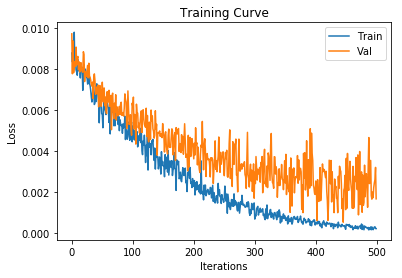

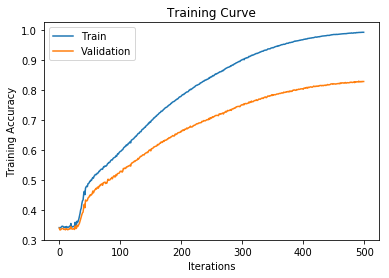

Final Training Accuracy: 0.9919224330357143
Final Validation Accuracy: 0.8282110091743119


In [0]:
train_all(model_all, train_data_all, val_data_all, batch_size=20, num_epochs=500, lr = 0.0002, shuffle = True, company_group = True, label_type = 0) 

In [0]:
test_accuracy = get_accuracy_all(model_all, test_data_all, 
             batch_size = 128, label_type = 0, print_out = False)

print("Final Test Accuracy: ", test_accuracy*100, "%")